# HackGTeeny AI Workshop

This is a Colaboratory notebook. Notebooks like this are often used in data science and machine learning because they provide a unified environment for code, text, and charts. 


**If you want to edit or interact with this notebook, use the `playground` button!**


---

# Topics

- Natural Language Processing (NLP) on old HackGT 4 submissions


## Setup

Cells can contain code or text. You can run a code by clicking the run button to the left or by pressing shift-enter.

Try running the cell below to make sure everything is working (make sure you've entered playground mode)

In [358]:
print("Hello world!")

Hello world!


Colaboratory has a lot of useful libraries installed automatically. Below are some standard imports that you'll see in nearly every single ML project.

In [359]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1.0: Pandas!
![](https://upload.wikimedia.org/wikipedia/commons/thumb/0/0f/Grosser_Panda.JPG/218px-Grosser_Panda.JPG)
  

---




- `pandas` is a staple library for machine learning and data science 
- Think of it as a **very** fast csv wrapper
  - sql style operations
  - charts
  - makes life easier by replacing lots of for loops


The main abstraction is a `DataFrame`, often as a variable called `df`.  
  
  When I say dataframe, think table.
  
  Most of the operations are pretty self explanatory. 
  
  Below, we'll read a CSV file that I've prepared containing submissions from HackGT last year. 
  

In [360]:
# this can also be a local (to the cloud instance) file!
location = 'https://gist.githubusercontent.com/ruyimarone/04d356038138f12df205da9934e797f1/raw/e3bb9212eae46e10f85b765f5a3ab95e0428c3ee/data.csv'
df = pd.read_csv(location)
# this drops any rows that have NaN values or other missing entries - we won't worry about them
df = df.dropna()
#this drops anything that is too short
df = df[df.description.str.len() > 100]

We can check the contents of a `DataFrame` by inspecting the first few rows:

In [361]:
df.head()

,submission,description,tags
0,Cinema4All,Inspiration\n\nWhen exploring different proble...,"azure, react, heroku, css, javascript"
1,helpr,Inspiration\n\nWhen considering the types of u...,"love, caffeine, android-studio, arduino, iot, ..."
2,Book Match: Vocabing,Inspiration\n\nGRE Test Prep\n\nWhat it does\n...,"python, mysql, azure, nltk, natural-language-p..."
3,Parking sensor,"Inspiration\n\nOne day, while driving, Sarah b...","arduino, pwm"
4,HackGTOne,Inspiration\n\nWe wanted to improve the custom...,"java, android"


We can also do advanced selections. For example, if we wanted every project that was tagged on devpost with python:

In [362]:
df[df.tags.str.contains('python') & df.tags.str.contains('pandas')].head()

,submission,description,tags
7,Airline Delays Visualization,Inspiration\n\nI love airplanes and big data i...,"pandas, numpy, python, jupyter-notebook"
92,Huber,Huber\n\nHuber is new. It's different. All you...,"typescript, jupyter-notebook, python, javascri..."
135,InvestFolio,Inspiration\n\nEasy to use. Free. \n\nWhat it ...,"php, google-cloud, scikit-learn, python, mysql..."


Let's compare some libraries and languages:

In [363]:
df[df['tags'].str.contains('python')].tags.count()

66

In [364]:
df[df['tags'].str.contains('node.js')].tags.count()

30

In [365]:
#TOOD should thie be here?

############
#Challenge!#
############


#if you are bored, use this cell to create a histogram/bar chart of tags
#use pandas and matplotlib as concisely and clearly as possible

## 2.0 NLP: Clustering Words


---

Back to the slides!





### 2.1 Getting Terms and Documents

Imports and boilerplate...

In [366]:
#also super common 
import nltk #natural language toolkit
import sklearn #python library for classical machine learning 

`CountVectorizer` : generates bag of word vectors

In [367]:
cv = sklearn.feature_extraction.text.CountVectorizer()
m = cv.fit_transform(['this is a document', 'this is a second document', 'third document document document']).todense()
print(cv.vocabulary_)
print(m)

{'this': 4, 'is': 1, 'document': 0, 'second': 2, 'third': 3}
[[1 1 0 0 1]
 [1 1 1 0 1]
 [3 0 0 1 0]]


Now we can get a term document matrix from the submissions dataframe. 


In [368]:
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer()
td_count_matrix = count_vectorizer.fit_transform(df['tags'])

Note that the count vectorizer handles tokenization for us. Tokenization broadly means turning a sentence into word or word like chunks. Easiest way - `sentence.split()` 

Let's see what the matrix looks like:

In [369]:
td_count_matrix.shape

(175, 305)

So we have 177 documents and 305 unique terms. 

Here's a snippet of the vocab, to convince you that the tokenization worked:

In [370]:
list(count_vectorizer.vocabulary_.items())[:10]

[('azure', 32),
 ('react', 234),
 ('heroku', 130),
 ('css', 69),
 ('javascript', 147),
 ('love', 168),
 ('caffeine', 48),
 ('android', 14),
 ('studio', 269),
 ('arduino', 23)]

### 2.2 Clustering Tags

In [371]:
from sklearn.decomposition import TruncatedSVD as SVD
svd = SVD(10)
svd.fit(td_count_matrix)

TruncatedSVD(algorithm='randomized', n_components=10, n_iter=5,
       random_state=None, tol=0.0)

`sklearn` provides us with very nice abstractions, calculating this complicated matrix decomposition is that simple. 

There are lots of things we can do with this matrix (like search), but for now let's examine the similar words:

In [372]:
from IPython.core.display import display, HTML
def tabulate(data):
    display_df = pd.DataFrame(data)
    display(HTML(display_df.to_html(index=False, header=True)))

In [373]:
data = []
for i in range(len(svd.components_)):
    scores = []
    words = []
    topk = sorted(zip(svd.components_[i], count_vectorizer.get_feature_names()), reverse=True)[:10]
    scores, words = zip(*topk)
    data.append(scores)
    data.append(words)
tabulate(data)
    #   print(' + '.join('{:.3f}
#     for c, word in topk:
#         sco

0,1,2,3,4,5,6,7,8,9
0.42948,0.405186,0.292172,0.239077,0.233803,0.210985,0.202825,0.194406,0.187247,0.171321
js,javascript,python,api,node,html,css,android,azure,html5
0.569338,0.305757,0.286337,0.212996,0.20583,0.195473,0.156635,0.10498,0.101562,0.091893
android,java,studio,google,api,firebase,maps,aws,microsoft,xml
0.531913,0.330386,0.272866,0.227208,0.144581,0.128783,0.106199,0.106149,0.0989417,0.0885997
api,bing,microsoft,azure,cognitive,search,ncr,maps,html5,css3
0.505707,0.303109,0.113103,0.106589,0.102589,0.102339,0.0768825,0.0764938,0.0702382,0.0597419
js,node,amazon,express,bing,services,alexa,maps,api,mongodb
0.524476,0.255974,0.245116,0.188623,0.108913,0.105491,0.09476,0.0929594,0.0641392,0.06366
python,flask,js,amazon,d3,ncr,unity,web,azure,machine


- These reduced features are linear combinations of the old ones
  - we could call the first one a webdev-ish dimension
  - there's also an ML/NLP dimension <3
- Not always interpretable
- SVD doesn't care about broader language - it only cares about co occurrences

Let's look at the actual matrix and see if it tells us anything useful:


In [374]:
#get the 50 most common tags
from collections import Counter
tag_counts = Counter()
for tags in df.tags.values:
    tag_counts.update((t for t in tags.split(', ') if t in count_vectorizer.vocabulary_))

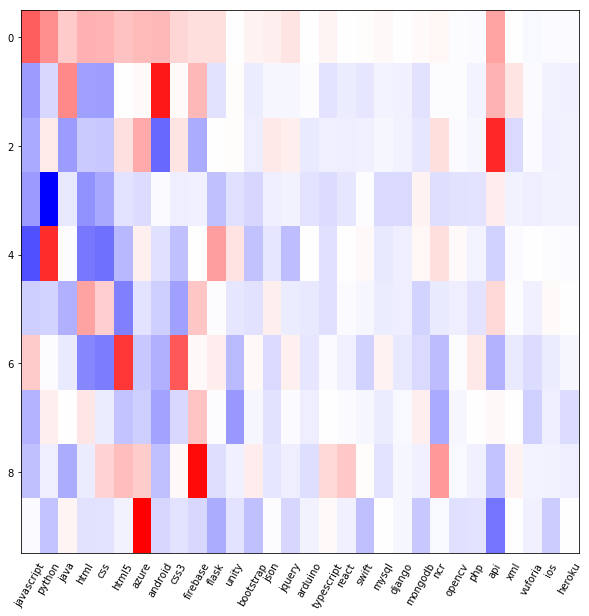

In [375]:
N = 30
ixs_of_interest = []
for tag, _ in tag_counts.most_common(N):
    ixs_of_interest.append(count_vectorizer.vocabulary_[tag])
mat = svd.components_[:, ixs_of_interest]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mat, aspect='auto', cmap='bwr')
ax.set_xticks(range(N))
ax.set_xticklabels([t for t, _ in tag_counts.most_common(N)], rotation=60)
ax.xaxis.set_ticks_position('none')

### 2.3 Clustering Documents

I'll repeat the experiment, using the full `descriptions` instead of just the `tags` columns. 

In [376]:
# vectorize the documents
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer()
td_count_matrix = count_vectorizer.fit_transform(df['description'])
svd = SVD(10)
svd.fit(td_count_matrix)

data = []
for i in range(len(svd.components_)):
    scores = []
    words = []
    topk = sorted(zip(svd.components_[i], count_vectorizer.get_feature_names()), reverse=True)[:10]
    scores, words = zip(*topk)
#     data.append(scores)
    data.append(words)
    
tabulate(data)

0,1,2,3,4,5,6,7,8,9
the,to,and,we,of,in,that,for,it,with
we,to,and,our,it,what,how,as,learned,that
and,to,is,you,my,it,app,this,or,what
to,ingredients,app,that,user,recipes,as,model,recipe,users
of,our,and,model,app,in,recipes,recipe,data,database
our,is,keyboard,that,be,would,could,one,have,keyboards
you,data,that,your,is,model,recipes,keyboard,then,recipe
and,the,we,you,api,will,microsoft,your,app,vision
data,for,app,predict_,if,is,price,our,amount,it
in,with,as,if,are,predict_,people,price,amount,you


- Those are boring
- Why?
  - Lots of confounding words!
  - Lots of useless co-occurrence data
    - it doesn't help me to know that *the* appears often with *application*

---

    
We can solve this!

Replace our bag of words with a bag of tricks:
- use **tf-idf** instead of basic word counts
- remove useless **stop words**

In [377]:
#I manually created this list so it would be easy to add your own as you experiment 
#In reality you could do something like filter the top N most frequent words (similar to IDF)
stop_words = ['the', 'to', 'we', 'and', 'of', 'it', 'in', 'for', 'with', 'is', 'this', 'my', \
              'that', 'our', 'what', 'on', 'as', 'you', 'was']
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stop_words) # this has lots of parameters - experiment!
# sklearn.feature_extraction.text.TfidfVectorizer?

In [378]:
# vectorize the documents
tfidf_matrix = tfidf_vectorizer.fit_transform(df['description'])
svd = SVD(10)
svd.fit(tfidf_matrix)
data = []
for i in range(len(svd.components_)):
    scores = []
    words = []
    topk = sorted(zip(svd.components_[i], tfidf_vectorizer.get_feature_names()), reverse=True)[:10]
    _, words = zip(*topk)
    data.append(words)
tabulate(data)

0,1,2,3,4,5,6,7,8,9
data,app,application,can,how,an,user,are,be,into
data,stock,analysis,fraud,sentiment,risk,finra,api,machine,python
alexa,game,unity,motion,skill,lambda,how,stock,myo,aws
alexa,skill,lambda,aws,bot,jira,node,voice,js,learnt
recipe,ingredients,recipes,ncr,end,items,your,ingredient,food,item
alexa,myo,food,unity,armband,drone,ncr,data,vr,ingredients
application,notes,will,students,vision,stock,microsoft,text,faces,image
bot,chatbot,chat,their,microsoft,faces,face,ar,questions,azure
parking,park,recipe,model,ingredients,bot,recipes,spots,car,parkme
unity,stock,end,location,api,motion,recipe,reality,virtual,front


## 3 Search

- We've shown how to vectorize documents
- We've shown that some of these vectors have semantic properties


In [379]:
import nltk

hack_documents = [
    "Use machine learning on text messages to predict when you are hungry.",
    "Tour college campuses using an oculus rift.",
    "Use blockchain to keep track of which roommate needs to take out the trash."
]

def tokenize(raw_text, vocab = None):
    tokens = []
    for sentence in nltk.sent_tokenize(raw_text):
        tokens += nltk.word_tokenize(sentence)
    tokens = [t.lower() for t in tokens if not vocab or t.lower() in vocab]
    return tokens

In [380]:
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=stop_words)
tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(tokenize(d)) for d in df['description']])
svd = SVD(10)
svd.fit(tfidf_matrix)

def cosine(a, b):
    eps = 1e-8
    if type(a) is np.ndarray:
        return a.dot(b) / ((np.linalg.norm(a) * np.linalg.norm(b)) + eps)
    else:
        return a.dot(b) / ((a.norm() * b.norm()) + eps)

def tfidf_model(query, document):
    query_vector = tfidf_vectorizer.transform([' '.join(tokenize(query, tfidf_vectorizer.get_feature_names()))]).todense()
    doc_vector = tfidf_vectorizer.transform([' '.join(tokenize(document, tfidf_vectorizer.get_feature_names()))]).todense()
    doc_vector = np.squeeze(np.asarray(doc_vector))
    query_vector = np.squeeze(np.asarray(query_vector))
    return cosine(query_vector, doc_vector)

def lsa_model(query, document):
    query = ' '.join(tokenize(query, tfidf_vectorizer.get_feature_names()))
    document = ' '.join(tokenize(document, tfidf_vectorizer.get_feature_names()))
    query_vector = tfidf_vectorizer.transform([query]).todense()
    doc_vector = tfidf_vectorizer.transform([document]).todense()
    query_vector = svd.transform(query_vector)
    doc_vector = svd.transform(doc_vector)
    return cosine(np.squeeze(np.asarray(doc_vector)), np.squeeze(np.asarray(query_vector)))
    
def search(model, query, documents, names = None):
    """
    """
    scores = [model(query, document) for document in documents]
    ixs = list(reversed(np.argsort(scores)[-10:]))
    print([scores[i] for i in ixs])
    print([documents[i][:150] for i in ixs])
    if names is not None:
        print([names[i] for i in ixs])
    
search(tfidf_model, "virtual reality", hack_documents)
search(lsa_model, "virtual reality", hack_documents)

[0.0, 0.0, 0.0]
['Use blockchain to keep track of which roommate needs to take out the trash.', 'Tour college campuses using an oculus rift.', 'Use machine learning on text messages to predict when you are hungry.']
[0.7081789560665279, 0.2911434720132211, -0.12304187931258342]
['Tour college campuses using an oculus rift.', 'Use blockchain to keep track of which roommate needs to take out the trash.', 'Use machine learning on text messages to predict when you are hungry.']


Here is a failure case

In [381]:
search(tfidf_model, "university visits", hack_documents)
search(lsa_model, "university visits", hack_documents)

[0.0, 0.0, 0.0]
['Use blockchain to keep track of which roommate needs to take out the trash.', 'Tour college campuses using an oculus rift.', 'Use machine learning on text messages to predict when you are hungry.']
[0.07417157830720489, -0.014738095089920748, -0.2595596221319571]
['Tour college campuses using an oculus rift.', 'Use machine learning on text messages to predict when you are hungry.', 'Use blockchain to keep track of which roommate needs to take out the trash.']


## 4. Deep Learning

In [310]:
import torch, torchtext
word2vecin = torchtext.vocab.Vectors('in_pruned.txt', cache = '.')
word2vecout = torchtext.vocab.Vectors('out_pruned.txt', cache = '.')

In [311]:
def get_doc_vector(tokens, embedding = word2vecout):
    q = sum(embedding[t] / embedding[t].norm() for t in tokens) / len(tokens)
    return q

def desm_model(query, document, embedding = word2vecin):
    query_tokens = tokenize(query, vocab=word2vecin.stoi)
    doc_tokens = tokenize(document, vocab=word2vecin.stoi)
    if len(doc_tokens) == 0:
        return -np.inf
    doc_vector = get_doc_vector(doc_tokens)
    return (sum(cosine(word2vecin[t], doc_vector) for t in query_tokens) / len(query_tokens)).item()

In [313]:
search(desm_model, "virtual reality", hack_documents)

[-0.03160405904054642, -0.0772206112742424, -0.08321691304445267]
['Tour college campuses using an oculus rift.', 'Use machine learning on text messages to predict when you are hungry.', 'Use blockchain to keep track of which roommate needs to take out the trash.']


In [223]:
search(desm_model, "natural language processing", hack_documents)

[-0.046359557658433914, -0.06493649631738663, -0.06661113351583481]
['Use machine learning on text messages to predict when you are hungry.', 'Tour college campuses using an oculus rift.', 'Use blockchain to keep track of which roommate needs to take out the trash.']


In [224]:
search(desm_model, "university visits", hack_documents)

[-0.06931082904338837, -0.06984560191631317, -0.08402836322784424]
['Tour college campuses using an oculus rift.', 'Use blockchain to keep track of which roommate needs to take out the trash.', 'Use machine learning on text messages to predict when you are hungry.']


Some more examples, with new dataset. These documents don't have any overlap with the words in the original hackgt 4 devpost dataset, so the tfidf and lsa models won't work. 

In [230]:
food_documents = [
    "A fruit stand selling fresh produce from local farms.",
    "Sushi prepared by master chefs with fresh caught local fish.",
    "Burgers and smoked meat, served with fries and your choice of sauces."
]

search(desm_model, "tuna", food_documents)

[-0.0026541328988969326, -0.008288722485303879, -0.06628800928592682]
['Sushi prepared by master chefs with fresh caught local fish.', 'Burgers and smoked meat, served with fries and your choice of sauces.', 'A fruit stand selling fresh produce from local farms.']


In [231]:
search(desm_model, "apple", food_documents)

[-0.004839772824198008, -0.06945089250802994, -0.08361394703388214]
['A fruit stand selling fresh produce from local farms.', 'Burgers and smoked meat, served with fries and your choice of sauces.', 'Sushi prepared by master chefs with fresh caught local fish.']


In [232]:
search(desm_model, "potato", food_documents)

[0.005773760844022036, -0.05793831869959831, -0.060402628034353256]
['Burgers and smoked meat, served with fries and your choice of sauces.', 'Sushi prepared by master chefs with fresh caught local fish.', 'A fruit stand selling fresh produce from local farms.']


And finally, searching over the full devpost submissions

In [318]:
search(desm_model, "natural language processing", df.description.values, df.submission.values)

[-0.046228110790252686, -0.048790693283081055, -0.04903928562998772, -0.05077099800109863, -0.05099250748753548, -0.051693666726350784, -0.05194386839866638, -0.05220391973853111, -0.05234260484576225, -0.052750471979379654]
['Voice powered personal assistant software is powerful but limited. We wanted to allow the functionality of such agents, such as Cortana, to be extende', 'Inspiration\n\nEasy to use. Free. \n\nWhat it does\n\nUses machine learning to take in stock data to predict future stock prices and determine whether to ho', "Inspiration\n\nFinra's copious amounts of data.\n\nWhat it does\n\nDetect firms at potentially high risk for committing fraud. And, tracking people through ", 'Inspiration\n\nA lot of schools and colleges are in high demand of note takers for students with certain disabilities and impairment. Therefore, we deci', 'Inspiration\n\nCurrent recommendation systems for stores work by logging online transactions, or by recording location timestamps in smart devi

In [382]:
poly = torchtext.vocab.Vectors('poly.txt', cache='.')

In [383]:
counts = Counter()
for doc in df.description:
    counts.update(tokenize(doc))
    
for doc in hack_documents:
    counts.update(tokenize(doc))
    
for doc in food_documents:
    counts.update(tokenize(doc))


v = set(counts.keys()) | set(poly.stoi.keys())
len(v)

101209

In [384]:
lines_of_interest = []
with open('out_pruned.txt', 'r') as f:
    for line in f:
        word = line.split(' ')[0].strip()
        if word in v:
            lines_of_interest.append(line)
            
with open('out_pruned_lite.txt', 'w') as f:
    for line in lines_of_interest:
        f.write(line)